In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')



In [2]:
def getData(ticker, start_date = '2015-01-01', end_date = '2024-07-05', interval = '1d'):
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    return data

tickers = {
    'AAPL': 'Apple Inc.',
    'JNJ': 'Johnson & Johnson',
    'JPM': 'JPMorgan Chase & Co.',
    'PG': 'Procter & Gamble Co.',
    'XOM': 'Exxon Mobil Corporation',
    'VZ': 'Verizon Communications Inc.',
    'DUK': 'Duke Energy Corporation',
    'AMZN': 'Amazon.com, Inc.',
    'BA': 'Boeing Co.',
    'SPG': 'Simon Property Group, Inc.'
}

# generate df
df = pd.DataFrame()
for ticker in tickers.keys():
    data = getData(ticker)
    data = data['Adj Close']
    data = data.rename(ticker)
    df = df.merge(data, how='outer', left_index=True, right_index=True)


df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AAPL,JNJ,JPM,PG,XOM,VZ,DUK,AMZN,BA,SPG
Date,,,,,,,,,,
2015-01-02,24.402174,80.554390,48.002335,69.090271,61.023273,29.318199,56.340080,15.426000,113.657227,116.013268
2015-01-05,23.714724,79.991806,46.512104,68.761742,59.353550,29.074711,55.528988,15.109500,112.870049,116.489021
2015-01-06,23.716955,79.598740,45.306099,68.448517,59.038025,29.368145,56.440609,14.764500,111.540634,119.731430
2015-01-07,24.049522,81.355949,45.375229,68.807587,59.636227,29.178619,56.621620,14.921000,113.272377,121.934776
2015-01-08,24.973555,81.995651,46.389194,69.594414,60.628860,29.804026,56.849503,15.023000,115.275276,121.759521
...,...,...,...,...,...,...,...,...,...,...
2024-06-27,214.100006,145.800003,198.072464,166.619995,114.900002,40.820000,100.589996,197.850006,182.509995,149.809998
2024-06-28,210.619995,146.160004,201.145432,164.919998,115.120003,41.240002,100.230003,193.250000,182.009995,151.800003
2024-07-01,216.750000,146.440002,204.317856,162.720001,114.959999,41.740002,99.349998,197.199997,186.699997,146.520004


In [25]:
def linear_regression_trend(y):
    # X values (index)
    x = np.arange(len(y))
    x = sm.add_constant(x)  # add a constant for the intercept

    # Fit the model
    model = sm.OLS(y, x).fit()

    # Extract the gradient (slope) and p-value
    gradient = model.params[1]
    p_value = model.pvalues[1]

    return gradient, p_value

def apply_linear_regression_to_window(df, window_size):
    gradients = []
    p_values = []

    for i in range(len(df) - window_size + 1):
        y = df['price'].iloc[i:i + window_size]
        gradient, p_value = linear_regression_trend(y)
        gradients.append(gradient)
        p_values.append(p_value)

    # Pad the results with NaN for the last 30 rows
    gradients.extend([np.nan] * (window_size - 1))
    p_values.extend([np.nan] * (window_size - 1))

    df['trend'] = list(zip(gradients, p_values))
    return df

def plot_stop_loss(trends, ticker ,num_bins=20):

  # Create histogram data
  hist_data, bin_edges = np.histogram(trends['rolling_drawdowns'], bins=num_bins)

  # Create data for direction == 1
  hist_data_1, _ = np.histogram(trends[trends['direction'] == 1]['rolling_drawdowns'], bins=bin_edges)

  # Create data for direction == -1
  hist_data_neg1, _ = np.histogram(trends[trends['direction'] == -1]['rolling_drawdowns'], bins=bin_edges)

  # Calculate the width of each bin
  bin_width = bin_edges[1] - bin_edges[0]

  # Create the histogram plot
  plt.figure(figsize=(12, 6))

  # Plot the total histogram
  plt.bar(bin_edges[:-1], hist_data, width=bin_width, align='edge', alpha=0.6, label='Total')

  # Plot the histogram for direction == 1
  plt.bar(bin_edges[:-1], hist_data_1, width=bin_width, align='edge', alpha=0.6, color='g', label='Positive slope')

  # Plot the histogram for direction == -1
  plt.bar(bin_edges[:-1], hist_data_neg1, width=bin_width, align='edge', alpha=0.6, color='r', label='Negative slope')

  # Add labels and title
  plt.xlabel('Rolling Drawdowns')
  plt.ylabel('Count')
  plt.title(tickers[ticker])
  plt.legend()

  # Show the plot
  plt.show()

def show_stop_loss(ticker, k=30, bins=50):
  A = df[ticker]
  D = (A.max()-A)/A.max()

  data = pd.DataFrame(data = {'price':A, 'drawdowns':D})
  data['rolling_max'] = data['price'].rolling(window=k, min_periods=1).max()
  data['rolling_drawdowns'] = (data['rolling_max'] - data['price']) / data['rolling_max']

  data = apply_linear_regression_to_window(data, k)[:-k+1]


  trends = data[['price','rolling_drawdowns', 'trend']]
  trends['direction'] = trends['trend'].apply(lambda x : -1 if x[0]<0 else 1)

  plot_stop_loss(trends, ticker, bins)
  # return trends


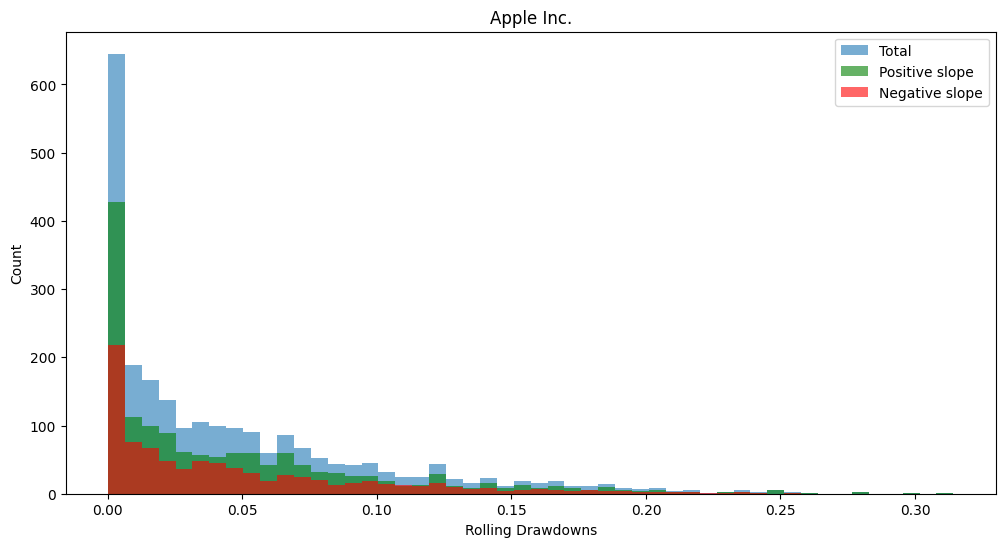

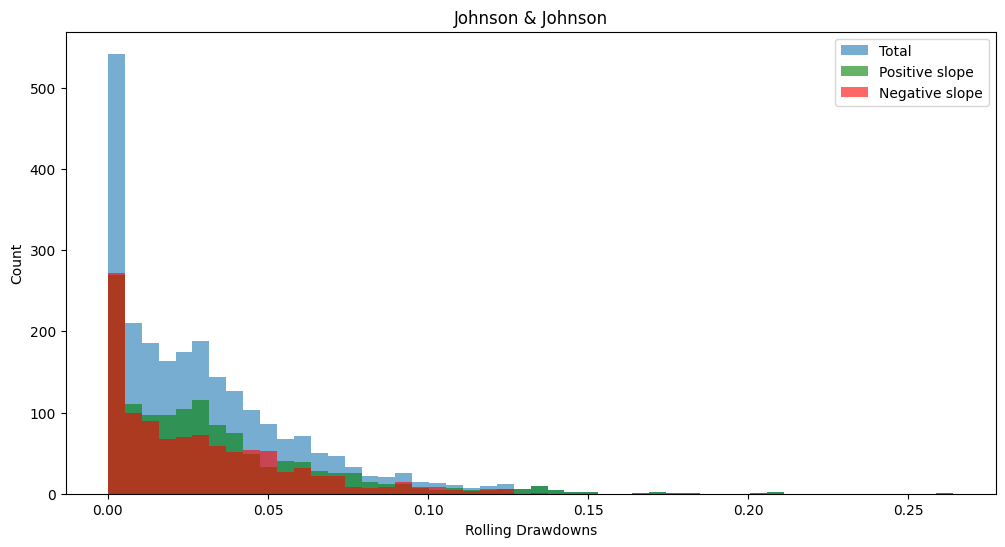

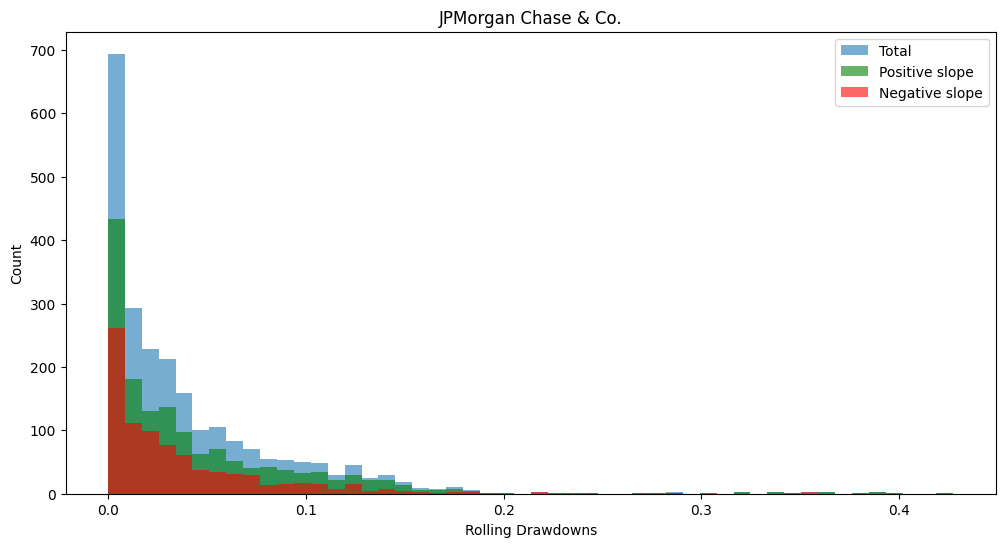

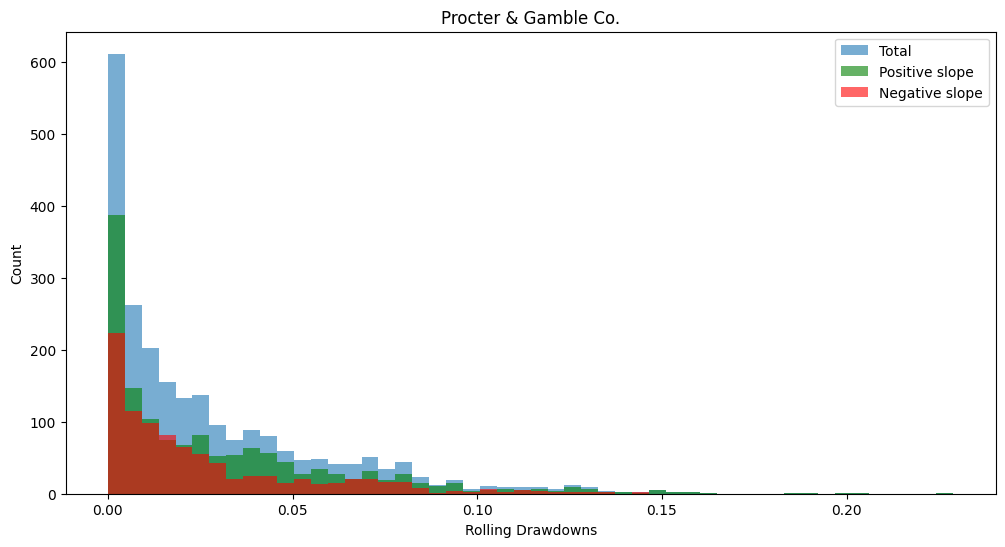

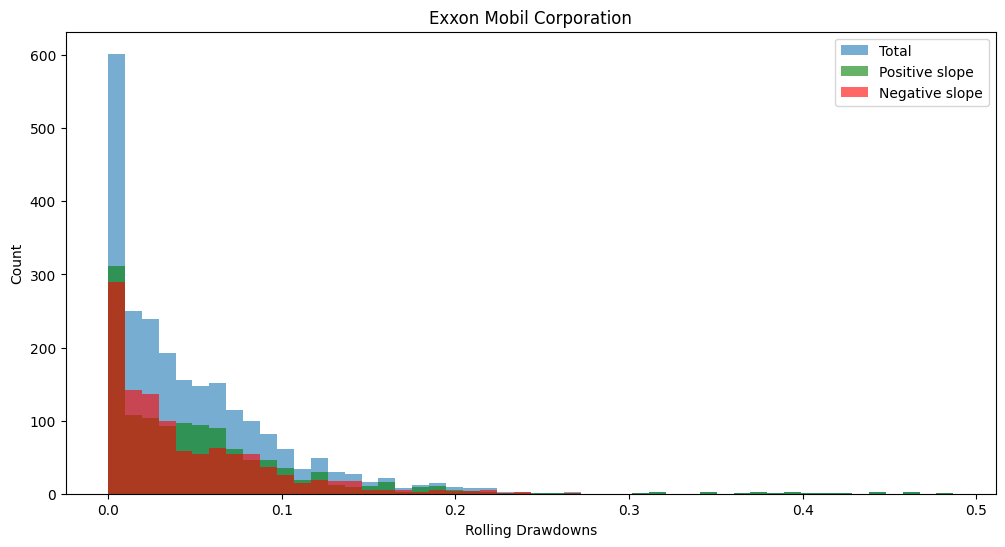

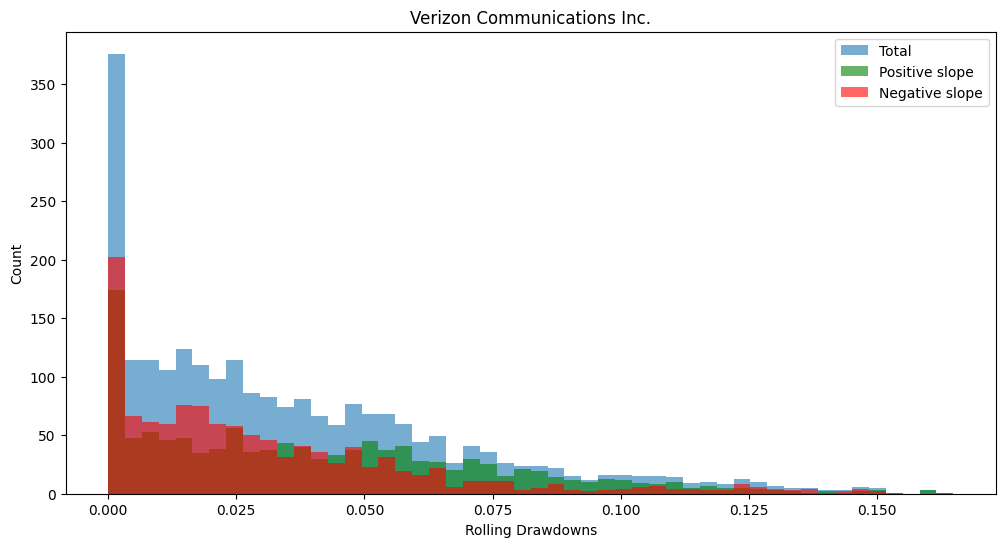

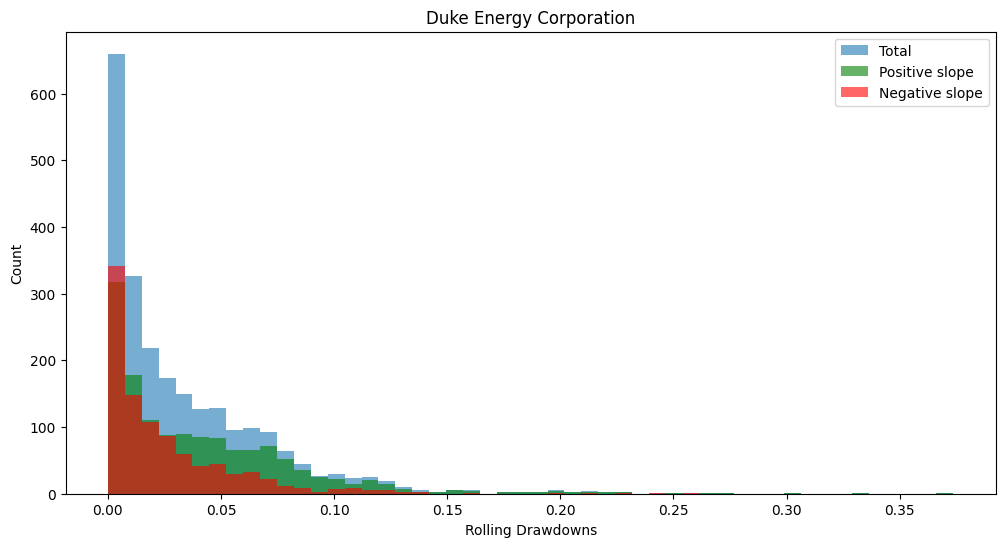

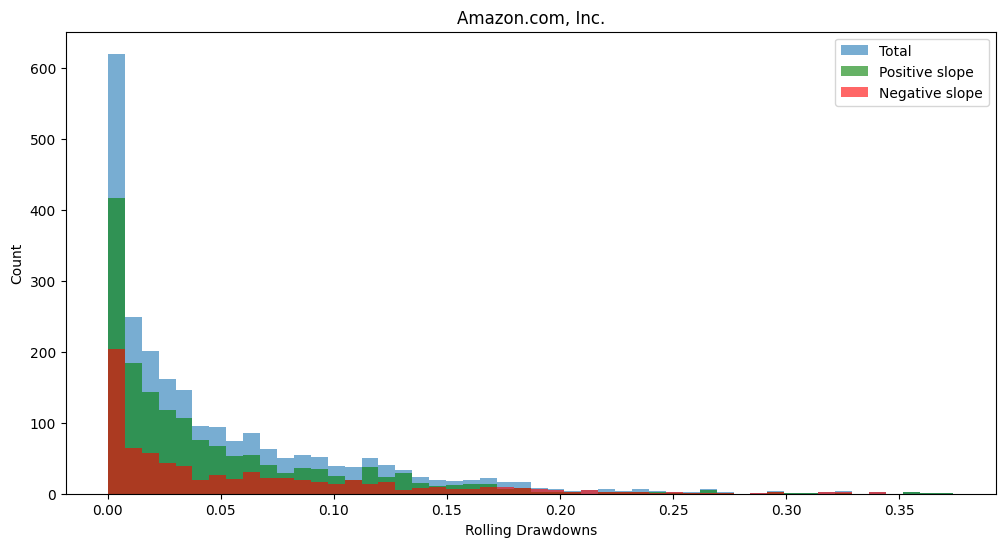

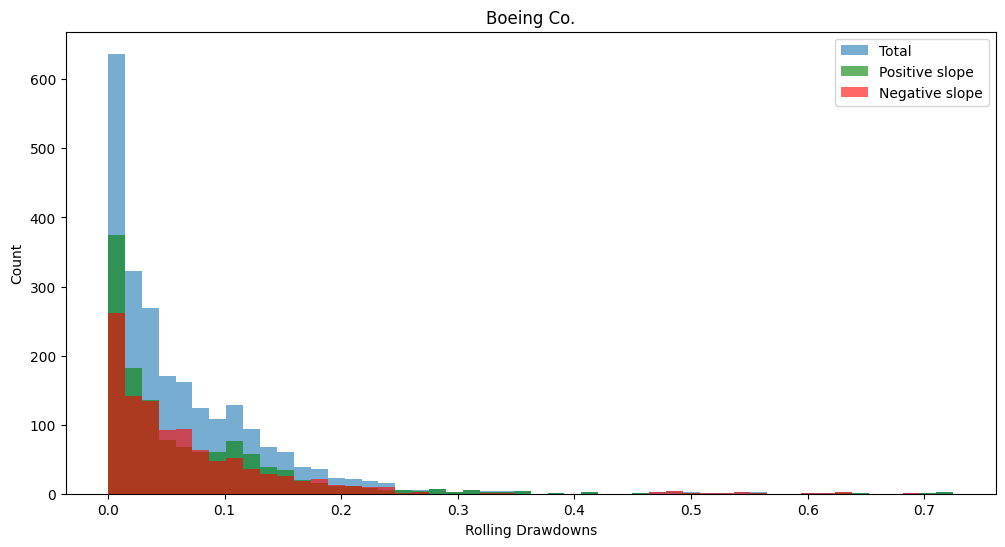

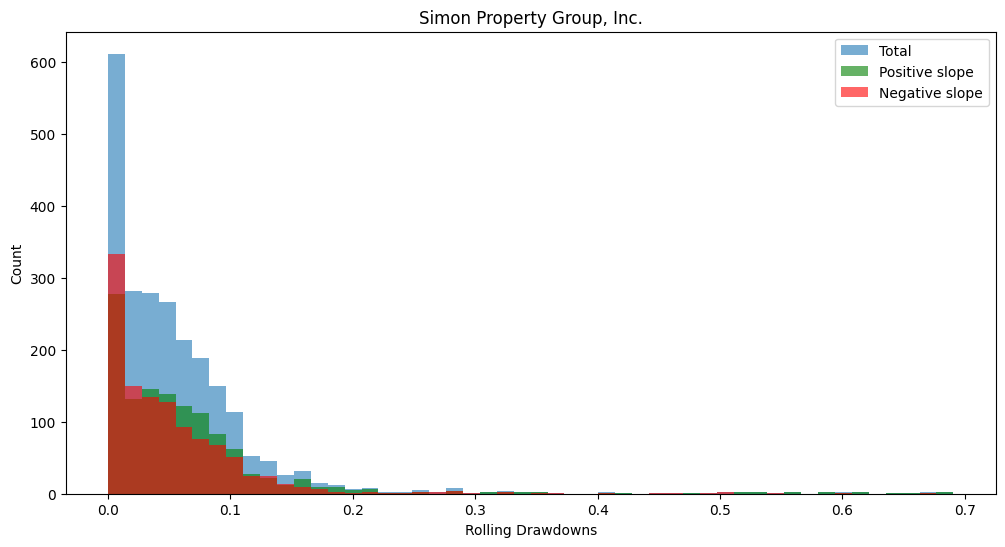

In [26]:
for ticker in tickers.keys():
  show_stop_loss(ticker, k=30)

# data = show_stop_loss('AAPL')
# data.rename(columns={'direction':'slope'}, inplace=True)
# data[['price', 'rolling_drawdowns', 'slope']].head()

,rolling_drawdowns,slope
Date,,
2015-01-05,0.028172,1
2015-01-06,0.028080,1
2015-01-07,0.014452,1
2015-01-12,0.024641,1
2015-01-13,0.015981,1
...,...,...
2024-05-02,0.019938,1
2024-05-06,0.009107,1
2024-05-07,0.005344,1
